In [8]:
import os
import io
#import requests
import random
import time
import numpy as np
import copy
import cv2
import pdb
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import itertools

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms, datasets
from torch.autograd import Variable
from torch.nn import functional as F
#from lime import lime_image

plt.ion()   # interactive mode
random.seed(42)

In [9]:
from MODEL import Deep_CNN
net = Deep_CNN()
net.load_state_dict(torch.load('best_deep_cnn_classification_layer5.pkl'))
net.eval()

DeepCNN(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(2,), bias=False)
    (1): GeLU()
  )
  (maxpool1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
        (1): GeLU()
        (2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (shortcut): Sequential(
        (0): Conv1d(32, 32, kernel_size=(1,), stride=(2,), bias=False)
      )
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): GeLU()
        (2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv1d(32, 64, kernel_size=(5

In [10]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

def register_hook(model, finalconv_name):
    model._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [11]:
register_hook(net, 'outchannel')

In [29]:
def return_cam(feature_conv, weight_softmax, class_idx, model_input_size):
    # generate the class activation maps upsample to 256x256
    size_upsample = model_input_size
    bz, nc, w = feature_conv.shape
    output_cam = []
    h=1
    print(weight_softmax[0].shape,feature_conv.shape)
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def calculate_cam(model, model_input_size, features_blobs, img_read_path, classes,img_data):
    # get the softmax weight
    params = list(model.cpu().parameters())
    weight_softmax = np.squeeze(params[-2].data.numpy())
    
    # preprocess image
    preprocess = transforms.Compose([
        #transforms.Resize(model_input_size),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    #img = Image.open(img_read_path)
    img_tensor = preprocess(img_data)
    img_variable = Variable(img_tensor)
    # get model prediction
    logit = model(img_variable)
    h_x = F.softmax(logit).data.squeeze()
    print(h_x)
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    
    # output the prediction
    #end = min(NUM_CLASSES, 5)
    #for i in range(0, end):
    #    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    
    # generate class activation mapping for the top1 prediction
    CAMs = return_cam(features_blobs[0], weight_softmax, [idx[0]], model_input_size)
    
    # render the CAM and output
    #print("Output CAM.jpg for the Top-1 Prediction: %s" % classes[idx[0]])
    img = cv2.resize(cv2.imread(img_read_path), model_input_size)
    height, width, _ = img.shape
    print(height,width)
    heatmap = cv2.applyColorMap(CAMs[0], cv2.COLORMAP_JET) #cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    cv2.imwrite("CAM.jpg", result)
    del features_blobs[:]
    return Image.open("CAM.jpg"), classes[idx[0]],h_x

In [30]:
def plot_images_cam(paths, model, input_size, features_blobs, class_names, img_data, columns=4, rows=2):
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle('Class Activation Mapping',fontsize=18,fontweight='medium')
    end = min(columns*rows+1, len(paths)+1)
    for i in range(1, end):
        img, pred,h_x = calculate_cam(model, input_size, features_blobs, paths[i-1], class_names,img_data[i-1])
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text("Predicted: {}".format(pred))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('Confidence A:%.2f F:%.2F G:%.2F K:%.2f'%(h_x[0],h_x[1],h_x[2],h_x[3]))
        plt.imshow(img)
        fig.savefig('Class_Activation_Mapping',dpi=1080)
    plt.show()

def create_path_list(base_path):
    path_list = []
    files = os.listdir(base_path)
    for _, file in enumerate(files):
        path_list.append(os.path.join(base_path, file))
    return path_list

tensor([9.9984e-01, 1.0795e-04, 5.3136e-05, 1.0564e-12])
(4,) (1, 4, 12)
288 432
tensor([2.1914e-14, 1.0000e+00, 1.0319e-10, 1.7218e-18])
(4,) (1, 4, 12)
288 432
tensor([5.4348e-12, 3.6019e-09, 1.0000e+00, 2.3974e-11])
(4,) (1, 4, 12)
288 432
tensor([1.5152e-33, 1.6739e-19, 9.5933e-20, 1.0000e+00])
(4,) (1, 4, 12)
288 432
tensor([1.0000e+00, 3.5437e-11, 2.0814e-12, 6.4108e-28])
(4,) (1, 4, 12)
288 432
tensor([8.6129e-05, 9.9991e-01, 2.4042e-11, 1.4848e-17])
(4,) (1, 4, 12)
288 432
tensor([1.2180e-15, 4.4477e-11, 1.0000e+00, 6.3832e-20])
(4,) (1, 4, 12)
288 432
tensor([2.4447e-24, 3.1875e-18, 2.4294e-08, 1.0000e+00])
(4,) (1, 4, 12)
288 432


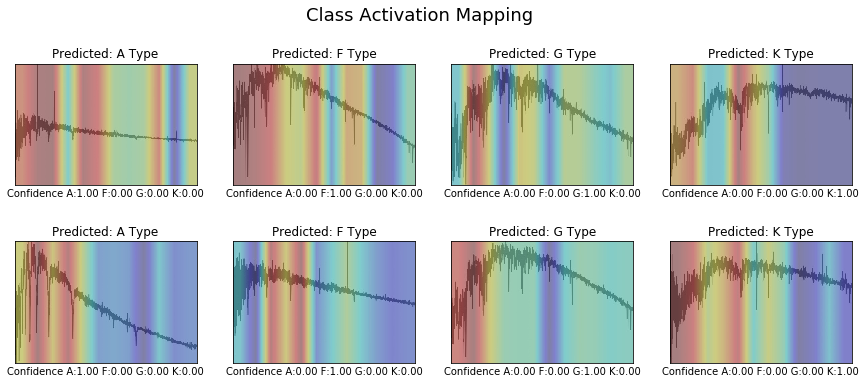

In [31]:
img_path1 = 'pic\A1_803222.png'
img_path2 = 'pic\F1_606239.png'
img_path3 = 'pic\G1_601041.png'
img_path4 = 'pic\K1_107103.png'
img_path5 = 'pic\A2_902029.png'
img_path6 = 'pic\F2_803162.png'
img_path7 = 'pic\G2_602142.png'
img_path8 = 'pic\K2_202065.png'

img_path = [img_path1,img_path2,img_path3,img_path4,img_path5,img_path6,img_path7,img_path8]
input_size = (432,288)
class_names = ['A Type','F Type','G Type','K Type']
img_data1 = np.loadtxt('D:\PycharmProjects\DataProcess/4类数据集/regression/A/803222.txt',delimiter=',', skiprows=0).astype('float32')[3:].reshape(1,-1)
img_data2 = np.loadtxt('D:\PycharmProjects\DataProcess/4类数据集/regression/F/606239.txt',delimiter=',', skiprows=0).astype('float32')[3:].reshape(1,-1)
img_data3 = np.loadtxt('D:\PycharmProjects\DataProcess/4类数据集/regression/G/601041.txt',delimiter=',', skiprows=0).astype('float32')[3:].reshape(1,-1)
img_data4 = np.loadtxt('D:\PycharmProjects\DataProcess/4类数据集/regression/K/107103.txt',delimiter=',', skiprows=0).astype('float32')[3:].reshape(1,-1)
img_data5 = np.loadtxt('D:\PycharmProjects\DataProcess/4类数据集/regression/A/902029.txt',delimiter=',', skiprows=0).astype('float32')[3:].reshape(1,-1)
img_data6 = np.loadtxt('D:\PycharmProjects\DataProcess/4类数据集/regression/F/803162.txt',delimiter=',', skiprows=0).astype('float32')[3:].reshape(1,-1)
img_data7 = np.loadtxt('D:\PycharmProjects\DataProcess/4类数据集/regression/G/602142.txt',delimiter=',', skiprows=0).astype('float32')[3:].reshape(1,-1)
img_data8 = np.loadtxt('D:\PycharmProjects\DataProcess/4类数据集/regression/K/202065.txt',delimiter=',', skiprows=0).astype('float32')[3:].reshape(1,-1)
img_data = [img_data1,img_data2,img_data3,img_data4,img_data5,img_data6,img_data7,img_data8]
#img, pred = calculate_cam(net, input_size, features_blobs, img_path, class_names,img_data)
#print("Predicted class: {}".format(pred))
#img
plot_images_cam(img_path, net, input_size, features_blobs, class_names, img_data, columns=4, rows=2)